# Dataset characterization

Let's have a look at this dataset.

In [1]:
import pandas as pd
import numpy as np
import polymetrizer
from openff.toolkit.topology import Molecule
from rdkit.Chem import ResonanceMolSupplier, rdMolDescriptors
from rdkit import Chem


In [2]:
SMIFILE = "openff_parsley_benchmark.smi"

## Dataframe

In [5]:
for x, v in dct.items():
    print(x, len(v))

SMILES 4061
n_atoms 4061
n_heavy_atoms 4061
n_conjugated_groups 4061
n_aliphatic_rings 4061
n_aromatic_rings (OE) 4061
n_aromatic_rings (RD) 4061
n_rings (SSSR) 4061
n_rings (Euler) 4061
n_rotatable_bonds (OE) 4061
n_rotatable_bonds (RD) 4061
n_heterocycles 4061
n_hba 4061
n_hbd 4061
C 4061
N 4061
O 4061
Cl 4061
F 4061
S 4061
P 4061
Br 4061
I 4065


In [6]:
from openeye.oechem import *
import tqdm
from openeye.oemolprop import (OEGetRotatableBondCount,
                               OEGetAromaticRingCount,
                               OEGetHBondAcceptorCount,
                               OEGetHBondDonorCount,
                              )

with open(SMIFILE, "r") as f:
    smiles = [x.strip() for x in f.readlines()]
    
dct = {x: [] for x in ["SMILES", "n_atoms", "n_heavy_atoms",
                       "n_conjugated_groups",
                       "n_aliphatic_rings",
                       "n_aromatic_rings (OE)", "n_aromatic_rings (RD)",
                       "n_rings (SSSR)", "n_rings (Euler)",
                       "n_rotatable_bonds (OE)", "n_rotatable_bonds (RD)",
                       "n_heterocycles",
#                        "n_stereocenters",
                       "n_hba",
                       "n_hbd",
                      ]}
elements = set()

for smi in tqdm.tqdm(smiles):
    mol = Molecule.from_smiles(smi, allow_undefined_stereo=True)
    try:
        rdmol = mol.to_rdkit()
    except:
        continue
    dct["SMILES"].append(smi)
    dct["n_atoms"].append(mol.n_atoms)
    heavy = [atom.element.symbol for atom in mol.atoms
             if atom.atomic_number != 1]
    dct["n_heavy_atoms"].append(len(heavy))
    
    oemol = mol.to_openeye()
    num_components, component_membership = OEDetermineComponents(oemol)
    num_rings = oemol.NumBonds() - oemol.NumAtoms() + num_components
    dct["n_rings (Euler)"].append(num_rings)
    dct["n_rotatable_bonds (OE)"].append(OEGetRotatableBondCount(oemol))
    dct["n_aromatic_rings (OE)"].append(OEGetAromaticRingCount(oemol))
    dct["n_hba"].append(OEGetHBondAcceptorCount(oemol))
    dct["n_hbd"].append(OEGetHBondDonorCount(oemol))
    

    suppl = ResonanceMolSupplier(rdmol)
    dct["n_conjugated_groups"].append(suppl.GetNumConjGrps())
    dct["n_aliphatic_rings"].append(rdMolDescriptors.CalcNumAliphaticRings(rdmol))
    dct["n_aromatic_rings (RD)"].append(rdMolDescriptors.CalcNumAromaticRings(rdmol))
    dct["n_rings (SSSR)"].append(rdMolDescriptors.CalcNumRings(rdmol))
    dct["n_rotatable_bonds (RD)"].append(rdMolDescriptors.CalcNumRotatableBonds(rdmol))
    dct["n_heterocycles"].append(rdMolDescriptors.CalcNumHeterocycles(rdmol))
#     dct["n_stereocenters"].append(rdMolDescriptors.CalcNumAtomStereoCenters(rdmol))
    

    # elements
    el, counts = np.unique(heavy, return_counts=True)
    el_set = set(el)
    for z, n in zip(el, counts):
        if z not in elements:
            dct[z] = [0] * (len(dct["SMILES"]) - 1)
            elements.add(z)
        dct[z].append(n)
    for z in elements - el_set:
        dct[z].append(0)
            
df = pd.DataFrame(dct)
df

  3%|█▏                                     | 122/4067 [00:00<00:11, 330.27it/s]RDKit ERROR: [18:45:58] Explicit valence for atom # 6 C, 5, is greater than permitted
[18:45:58] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [18:45:58] Explicit valence for atom # 6 C, 5, is greater than permitted
[18:45:58] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [18:45:58] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:45:58] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [18:45:58] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:45:58] Explicit valence for atom # 2 C, 5, is greater than permitted
 12%|████▋                                  | 493/4067 [00:01<00:16, 221.28it/s]RDKit ERROR: [18:45:59] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:45:59] Explicit valence for atom # 2 C, 5, is greater than permitted
 32%|████████████▎                         | 

,SMILES,n_atoms,n_heavy_atoms,n_conjugated_groups,n_aliphatic_rings,n_aromatic_rings (OE),n_aromatic_rings (RD),n_rings (SSSR),n_rings (Euler),n_rotatable_bonds (OE),...,n_hbd,C,N,O,Cl,F,S,P,Br,I
0,C#CCNC(=O)c1ccc2c(c1)CCCC2,31,16,1,1,1,1,2,2,2,...,1,14,1,1,0,0,0,0,0,0
1,C#CCN[C@@H]1CCc2c1cccc2,26,13,1,1,1,1,2,2,2,...,1,12,1,0,0,0,0,0,0,0
2,C#CC[NH2+][C@@H]1CCc2c1cccc2,27,13,1,1,1,1,2,2,2,...,2,12,1,0,0,0,0,0,0,0
3,C#Cc1cccc(c1)NC(=O)N2CCc3ccccc3C2,37,21,2,1,2,2,3,3,1,...,1,18,2,1,0,0,0,0,0,0
4,C#Cc1cccc(c1)NC(=O)c2cc(c(nc2)Cl)Cl,27,19,1,0,2,2,2,2,2,...,1,14,2,1,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4056,c1nc2c(nc(nc2n1[C@H]3[C@H]([C@@H]([C@H](O3)CO[...,35,24,1,2,1,1,3,3,4,...,4,10,5,7,0,1,0,1,0,0
4057,c1nc2c(nc(nc2n1[C@H]3[C@H]([C@@H]([C@H](O3)CO[...,36,24,1,2,1,1,3,3,4,...,5,10,5,7,0,1,0,1,0,0
4058,c1ncnc(n1)N2CCCC2,21,11,1,1,1,1,2,2,1,...,0,7,4,0,0,0,0,0,0,0
4059,c1nncn1CC(=O)N2CC[C@@]3(C2)CCCNC3=O,36,19,3,3,0,0,3,3,2,...,1,12,5,2,0,0,0,0,0,0


In [7]:
tidy = df.melt(id_vars=["SMILES"], value_name="Value", var_name="Property")
tidy

,SMILES,Property,Value
0,C#CCNC(=O)c1ccc2c(c1)CCCC2,n_atoms,31
1,C#CCN[C@@H]1CCc2c1cccc2,n_atoms,26
2,C#CC[NH2+][C@@H]1CCc2c1cccc2,n_atoms,27
3,C#Cc1cccc(c1)NC(=O)N2CCc3ccccc3C2,n_atoms,37
4,C#Cc1cccc(c1)NC(=O)c2cc(c(nc2)Cl)Cl,n_atoms,27
...,...,...,...
89337,c1nc2c(nc(nc2n1[C@H]3[C@H]([C@@H]([C@H](O3)CO[...,I,0
89338,c1nc2c(nc(nc2n1[C@H]3[C@H]([C@@H]([C@H](O3)CO[...,I,0
89339,c1ncnc(n1)N2CCCC2,I,0
89340,c1nncn1CC(=O)N2CC[C@@]3(C2)CCCNC3=O,I,0


In [8]:
df.to_csv("02_rdkit_parsley_benchmark_properties.csv")

In [9]:
len(tidy.SMILES.unique())

4061

In [10]:
len(tidy.Property.unique())

22

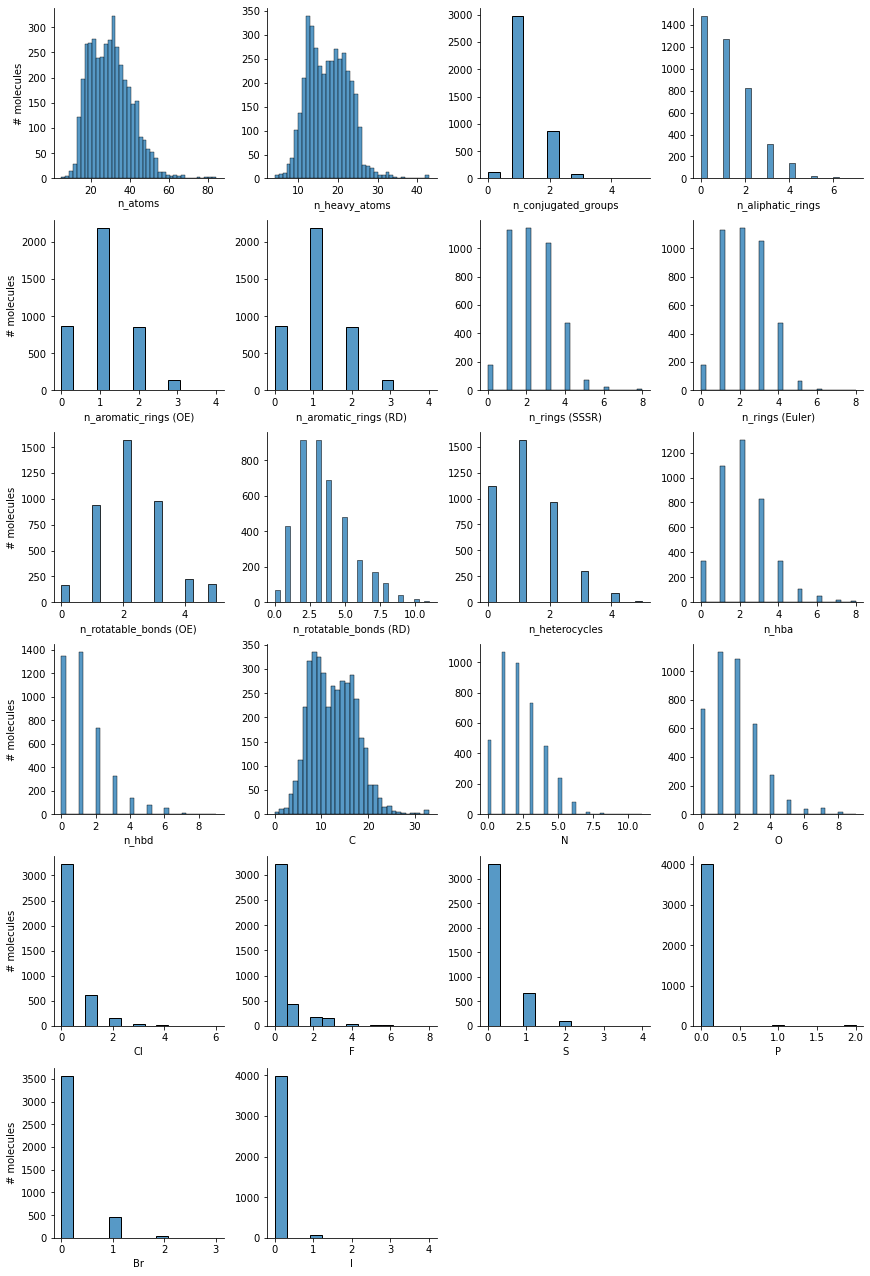

In [11]:
import seaborn as sns

g = sns.FacetGrid(data=tidy, col="Property", col_wrap=4, sharex=False, sharey=False)
g.map(sns.histplot, "Value", kde=False)
for i, (ax, title) in enumerate(zip(g.axes.flat, tidy.Property.unique())):
    ax.set_xlabel(title)
    if not i % 4:
        ax.set_ylabel("# molecules")
g.set_titles(col_template="")
g.savefig("02_rdkit_parsley_benchmark_properties.png", dpi=300)